In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


def load_json(file_path):
    data = []
    with open(file_path, 'r') as f:
        line = f.readline()
        while line:
            data.append(json.loads(line))
            line = f.readline()
    return pd.DataFrame(data)


def calculate_overall_statistics(df):
    total_time = df['total_time']
    percentiles = np.percentile(total_time, [50, 75, 85, 90, 95, 99])
    
    overall_stats = {
        'avg': total_time.mean(),
        'max': total_time.max(),
        'p50': percentiles[0],
        'p75': percentiles[1],
        'p85': percentiles[2],
        'p90': percentiles[3],
        'p95': percentiles[4],
        'p99': percentiles[5]
    }
    
    return pd.DataFrame([overall_stats])


def calculate_statistics(df):
    bin_size = 5000000
    df = df.copy()
    df.loc[:, 'gas_used_range'] = pd.cut(df['gas_used'], bins=np.arange(0, df['gas_used'].max() + bin_size, bin_size))
    
    grouped = df.groupby('gas_used_range', observed=False)['total_time']

    def under_1_sec_percentage(x):
        return (x < 1).sum() / x.count() * 100

    def under_2_sec_percentage(x):
        return (x < 2).sum() / x.count() * 100

    distribution = grouped.agg(
        avg='mean',
        max='max',
        p50=lambda x: np.percentile(x, 50),
        p75=lambda x: np.percentile(x, 75),
        p85=lambda x: np.percentile(x, 85),
        p90=lambda x: np.percentile(x, 90),
        p95=lambda x: np.percentile(x, 95),
        p99=lambda x: np.percentile(x, 99),
        count='count',
        under_1s_rate=under_1_sec_percentage,
        under_2s_rate=under_2_sec_percentage,
    ).reset_index()

    overall_under_1_sec_percentage = under_1_sec_percentage(df['total_time'])
    overall_under_2_sec_percentage = under_2_sec_percentage(df['total_time'])

    overall_stats = calculate_overall_statistics(df).iloc[0]
    max_gas_used = int((df['gas_used'].max() + bin_size) / bin_size) * bin_size 
    overall_stats['gas_used_range'] = f"(0, {max_gas_used}]"
    overall_stats['count'] = df['total_time'].count()
    overall_stats['under_1s_rate'] = overall_under_1_sec_percentage
    overall_stats['under_2s_rate'] = overall_under_2_sec_percentage

    distribution = pd.concat([distribution, pd.DataFrame([overall_stats])], ignore_index=True)

    return distribution, overall_under_1_sec_percentage, grouped


def plot_histogram(grouped, gas_range):
    total_times = grouped.get_group(gas_range)

    plt.figure(figsize=(10, 6))
    plt.hist(total_times, bins=50, edgecolor='black')
    plt.title(f'Histogram of total_time for gas_used_range {gas_range}')
    plt.xlabel('total_time')
    plt.ylabel('count')
    plt.grid(True)
    plt.show()

In [2]:
df_archive = load_json('base_archive.json')
df_full = load_json('base_full.json')
df_reth = load_json('base_reth.json')

common_blocks = set(df_archive['block_number']).intersection(df_full['block_number']).intersection(df_reth['block_number'])

df_archive = df_archive[df_archive['block_number'].isin(common_blocks)]
df_full = df_full[df_full['block_number'].isin(common_blocks)]
df_reth = df_reth[df_reth['block_number'].isin(common_blocks)]

distribution_archive, under_1_sec_archive, grouped_archive = calculate_statistics(df_archive)
distribution_full, under_1_sec_full, grouped_full = calculate_statistics(df_full)
distribution_reth, under_1_sec_reth, grouped_reth = calculate_statistics(df_reth)

In [3]:
print(f"op-geth archive node | base-mainnet {min(common_blocks)} ~ {max(common_blocks)} | {under_1_sec_archive:.4f}% is under 1s")
distribution_archive

op-geth archive node | base-mainnet 602976 ~ 4854299 | 99.6822% is under 1s


,gas_used_range,avg,max,p50,p75,p85,p90,p95,p99,count,under_1s_rate,under_2s_rate
0,"(0, 5000000]",0.021270,6.134,0.016,0.027,0.033,0.038,0.048,0.13200,3785712,99.984547,99.998891
1,"(5000000, 10000000]",0.164274,7.466,0.074,0.126,0.380,0.450,0.539,0.91300,130849,99.138702,99.554448
2,"(10000000, 15000000]",0.298745,7.367,0.167,0.427,0.573,0.675,0.762,1.70232,28957,98.342370,99.167731
3,"(15000000, 20000000]",0.326206,6.835,0.274,0.308,0.339,0.370,0.575,1.95876,107663,97.036122,99.037738
4,"(20000000, 25000000]",0.361215,8.023,0.273,0.369,0.422,0.473,0.853,1.94414,88087,95.733763,99.041856
5,"(25000000, 30000000]",0.478423,9.174,0.413,0.480,0.527,0.614,0.777,2.94415,110056,96.028386,98.111870
6,"(0, 30000000]",0.054162,9.174,0.019,0.032,0.046,0.092,0.296,0.54900,4251324,99.682170,99.886529


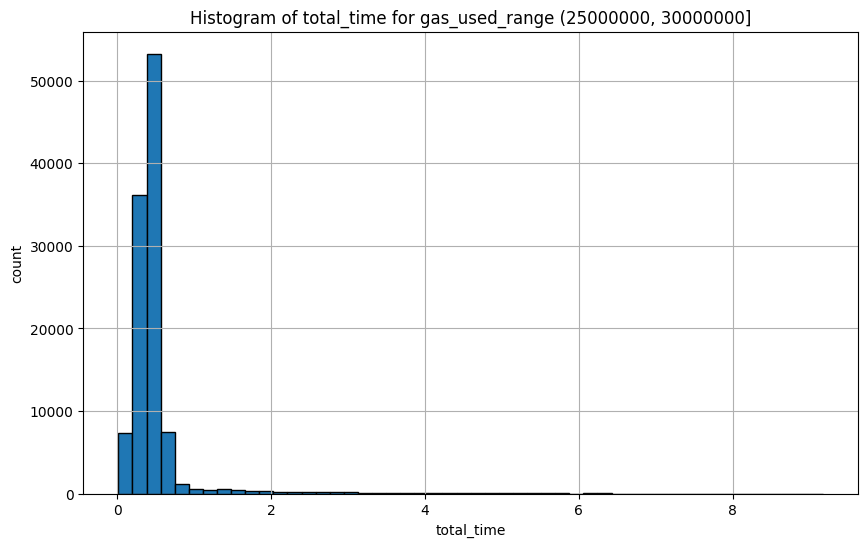

In [4]:
plot_histogram(grouped_archive, distribution_archive.loc[5, 'gas_used_range'])

In [5]:
print(f"op-geth full node | base-mainnet {min(common_blocks)} ~ {max(common_blocks)} | {under_1_sec_full:.4f}% is under 1s")
distribution_full

op-geth full node | base-mainnet 602976 ~ 4854299 | 99.9823% is under 1s


,gas_used_range,avg,max,p50,p75,p85,p90,p95,p99,count,under_1s_rate,under_2s_rate
0,"(0, 5000000]",0.019478,0.948,0.017,0.028,0.035,0.0400,0.048,0.069,3785712,100.000000,100.000000
1,"(5000000, 10000000]",0.111580,2.784,0.075,0.117,0.212,0.2730,0.331,0.506,130849,99.952617,99.992358
2,"(10000000, 15000000]",0.199955,2.893,0.158,0.253,0.340,0.4174,0.501,0.614,28957,99.865318,99.993093
3,"(15000000, 20000000]",0.192685,2.734,0.178,0.217,0.234,0.2480,0.288,0.454,107663,99.885755,99.998142
4,"(20000000, 25000000]",0.241352,4.982,0.231,0.272,0.299,0.3190,0.384,0.827,88087,99.659428,99.990918
5,"(25000000, 30000000]",0.276612,5.506,0.276,0.318,0.342,0.3750,0.426,0.579,110056,99.793741,99.995457
6,"(0, 30000000]",0.039183,5.506,0.020,0.034,0.047,0.0730,0.202,0.331,4251324,99.982335,99.999365


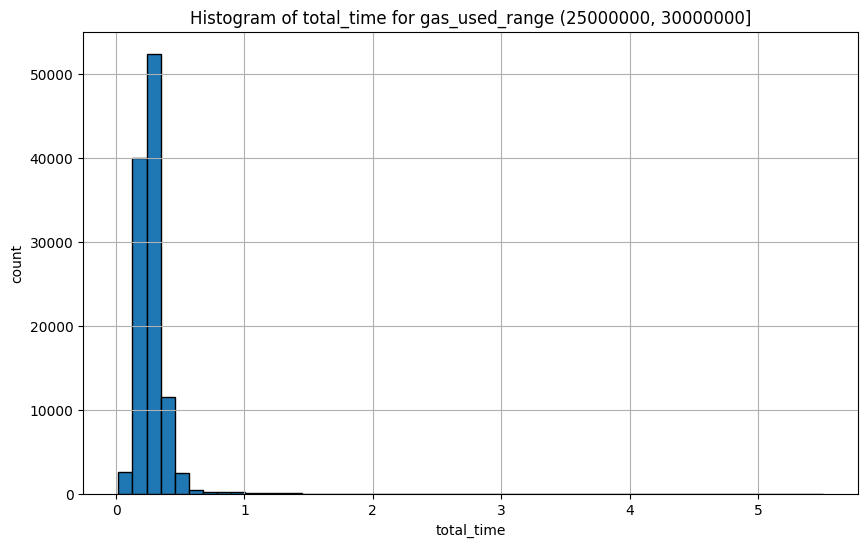

In [6]:
plot_histogram(grouped_full, distribution_full.loc[5, 'gas_used_range'])

In [7]:
print(f"op-reth archive node | base-mainnet {min(common_blocks)} ~ {max(common_blocks)} | {under_1_sec_reth:.4f}% is under 1s")
distribution_reth

op-reth archive node | base-mainnet 602976 ~ 4854299 | 99.0061% is under 1s


,gas_used_range,avg,max,p50,p75,p85,p90,p95,p99,count,under_1s_rate,under_2s_rate
0,"(0, 5000000]",0.031017,1.992,0.028,0.047,0.0580,0.0650,0.0780,0.10900,3785712,99.999577,100.000000
1,"(5000000, 10000000]",0.197661,4.490,0.093,0.166,0.3800,0.5560,0.7730,1.21300,130849,97.284656,99.862437
2,"(10000000, 15000000]",0.354739,5.948,0.196,0.454,0.6976,0.9124,1.1202,1.90900,28957,91.722209,99.374935
3,"(15000000, 20000000]",0.427561,8.845,0.361,0.474,0.6090,0.7100,0.9059,1.48800,107663,96.013487,99.679556
4,"(20000000, 25000000]",0.474619,7.087,0.344,0.559,0.7720,0.9340,1.2840,2.17728,88087,91.694575,98.653604
5,"(25000000, 30000000]",0.716476,13.781,0.580,0.965,1.0950,1.1960,1.4850,2.16900,110056,77.574144,98.553464
6,"(0, 30000000]",0.075330,13.781,0.033,0.056,0.0750,0.1060,0.3680,0.99800,4251324,99.006074,99.918049


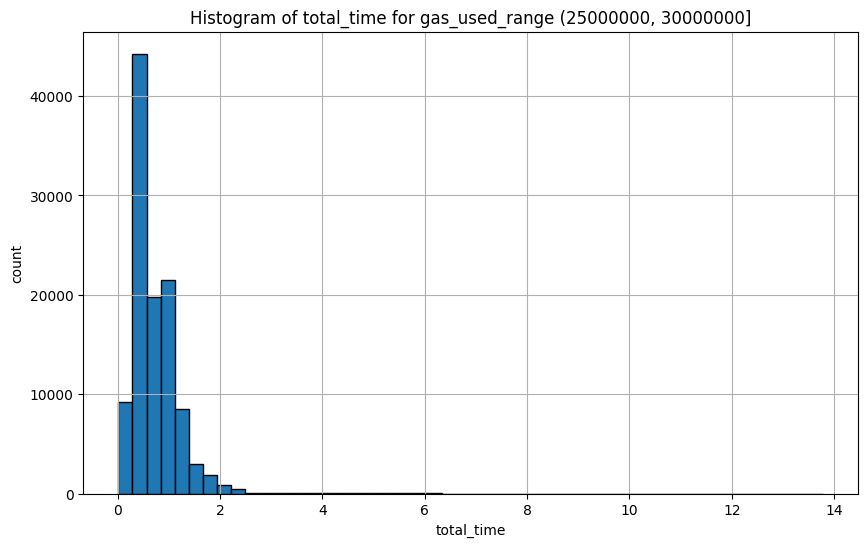

In [8]:
plot_histogram(grouped_reth, distribution_reth.loc[5, 'gas_used_range'])

In [9]:
df_snapshot_archive = load_json('base_snapshot_archive.json')
df_snapshot_full = load_json('base_snapshot_full.json')

distribution_snapshot_archive, under_1_sec_snapshot_archive, grouped_snapshot_archive = calculate_statistics(df_snapshot_archive)
distribution_snapshot_full, under_1_sec_snapshot_full, grouped_snapshot_full = calculate_statistics(df_snapshot_full)

In [10]:
print(f"op-geth archive node | base-mainnet {min(df_snapshot_archive['block_number'])} ~ {max(df_snapshot_archive['block_number'])} | {under_1_sec_snapshot_archive:.4f}% is under 1s")
distribution_snapshot_archive

op-geth archive node | base-mainnet 13686867 ~ 14231488 | 98.6045% is under 1s


,gas_used_range,avg,max,p50,p75,p85,p90,p95,p99,count,under_1s_rate,under_2s_rate
0,"(0, 5000000]",0.098488,2.429,0.091,0.102,0.113,0.1270,0.15800,0.22200,20958,99.608741,99.966600
1,"(5000000, 10000000]",0.167425,4.473,0.149,0.174,0.195,0.2160,0.25400,0.37500,327212,99.460594,99.811743
2,"(10000000, 15000000]",0.248335,5.141,0.208,0.244,0.277,0.3060,0.35900,1.49300,133615,98.629645,99.422221
3,"(15000000, 20000000]",0.402812,5.163,0.282,0.347,0.407,0.4630,0.99635,2.93194,36354,95.001926,97.001705
4,"(20000000, 25000000]",0.514981,5.304,0.359,0.455,0.524,0.6159,1.81590,3.27227,14792,93.374797,95.463764
5,"(25000000, 30000000]",0.683756,5.252,0.424,0.521,0.634,0.9500,3.14950,4.55770,11691,90.377213,92.498503
6,"(0, 30000000]",0.220858,5.304,0.170,0.224,0.268,0.3070,0.39200,1.59700,544622,98.604537,99.259486


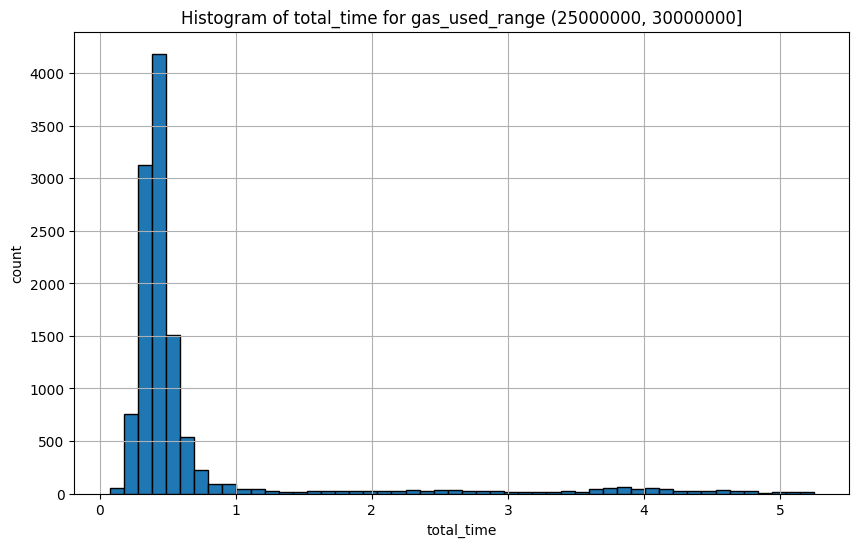

In [11]:
plot_histogram(grouped_snapshot_archive, distribution_snapshot_archive.loc[5, 'gas_used_range'])

In [12]:
print(f"op-geth full node | base-mainnet {min(df_snapshot_full['block_number'])} ~ {max(df_snapshot_full['block_number'])} | {under_1_sec_snapshot_full:.4f}% is under 1s")
distribution_snapshot_full

op-geth full node | base-mainnet 14567037 ~ 14777068 | 99.6872% is under 1s


,gas_used_range,avg,max,p50,p75,p85,p90,p95,p99,count,under_1s_rate,under_2s_rate
0,"(0, 5000000]",0.083512,0.624,0.081,0.088,0.093,0.099,0.13200,0.16800,17224,100.000000,100.000000
1,"(5000000, 10000000]",0.132785,4.430,0.125,0.144,0.155,0.166,0.19800,0.26700,115437,99.985273,99.997401
2,"(10000000, 15000000]",0.193933,3.763,0.177,0.201,0.218,0.239,0.28200,0.56900,50583,99.663919,99.976277
3,"(15000000, 20000000]",0.279978,3.095,0.235,0.270,0.308,0.348,0.52565,1.28600,14068,98.094967,99.879158
4,"(20000000, 25000000]",0.340245,4.730,0.297,0.341,0.380,0.430,0.61300,1.31200,6477,97.915702,99.907365
5,"(25000000, 30000000]",0.364582,4.066,0.340,0.382,0.418,0.460,0.54190,1.01574,6243,98.926798,99.951946
6,"(0, 30000000]",0.166618,4.730,0.142,0.186,0.221,0.254,0.31900,0.57400,210032,99.687191,99.980479


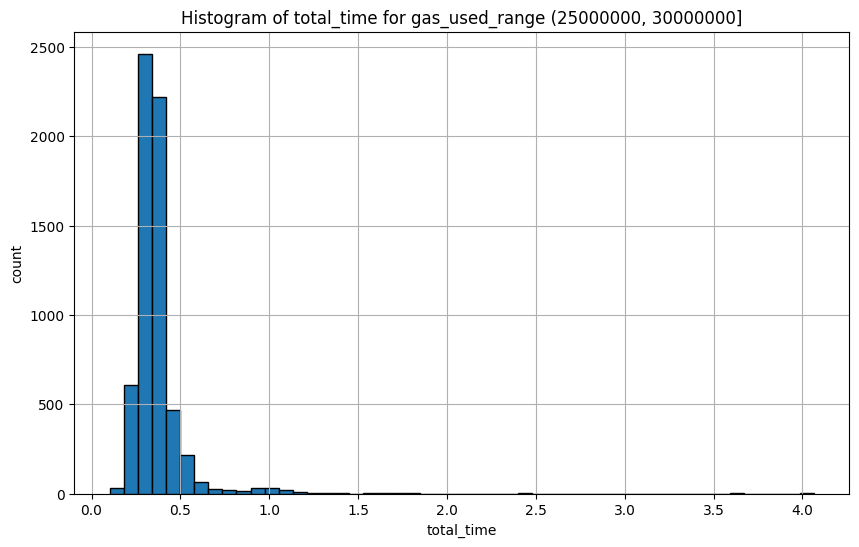

In [13]:
plot_histogram(grouped_snapshot_full, distribution_snapshot_full.loc[5, 'gas_used_range'])